# Final Dataset Implementation

In [1]:
#Exploratory data analysis packages
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import keras

# Machine Learning Packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
dataset=pd.read_csv("Ultimate.csv")#final_training_set.csv

In [3]:
dataset.head(5)

,url,label
0,https://www.drive.google.com,0
1,www.gmail.google.com,0
2,http://facebook.com,0
3,https://yahoo.com,0
4,001web.net,1


In [4]:
dataset.tail(5)

,url,label
3655309,23.227.196.215/,1
3655310,apple-checker.org/,1
3655311,apple-iclods.org/,1
3655312,apple-uptoday.org/,1
3655313,apple-search.info,1


In [5]:
dataset.shape

(3655314, 2)

In [6]:
dataset.groupby(by='label').count()

,url
label,
0,2442225
1,1213089


In [7]:
#Check for any missing data. If the output is not 0 then there is a value missing in the data set
dataset.isnull().sum().sum()

0

In [8]:
# Labels which indicate if an URL is spam or ham
#from sklearn.preprocessing import LabelEncoder

#LE = LabelEncoder()
#dataset['label'] = LE.fit_transform(dataset['label'])

#print(dataset['label'])


In [9]:
y = dataset["label"]
y.count()

3655314

0    2442225
1    1213089
Name: label, dtype: int64


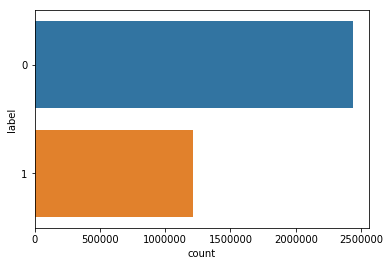

In [10]:
import seaborn
print(dataset["label"].value_counts())
seaborn.countplot(y="label", data=dataset)

In [11]:
# Features here are the URLs
url_list = dataset["url"]
url_list.count()

3655314

In [12]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re, os
from string import printable
from sklearn import model_selection

import tensorflow as tf
from keras.models import Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, SpatialDropout1D, Bidirectional
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [13]:
max_len = 400

In [14]:
checkpoint_path = 'weightsU.best.hdf5'
# Create checkpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, 
                                              monitor='val_loss', 
                                              verbose=1, 
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='min', #min for loss and max for accuracy
                                              period=1)

In [15]:
# stop training as soon as the validaion loss does not change significantly. 
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=5, 
                              verbose=0, 
                              mode='auto', 
                              baseline=None)

In [16]:
# Initial Data Preparation URL
#Convert raw URL string in list of lists where characters that are contained in 
# "printable" are stored encoded as integer 
import re

# remove https/http/www.
l = re.compile(r"https?://(www\.)?")
r = re.compile(r"(www\.)?")
urls = [l.sub('', url).strip().strip('/')for url in dataset.url]
urls = [r.sub('',url)for url in urls]

# convert url to tokens
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable ] for url in urls]

len(url_int_tokens)
print(urls[0:6])

['drive.google.com', 'gmail.google.com', 'facebook.com', 'yahoo.com', '001web.net', '005mall.com']


In [17]:
print(dataset.url[0])
print(urls[0])
print(url_int_tokens[0])
print(dataset.url[10080])
print(urls[10080])
print(url_int_tokens[10080])

https://www.drive.google.com
drive.google.com
[14, 28, 19, 32, 15, 76, 17, 25, 25, 17, 22, 15, 76, 13, 25, 23]
1016-techpro.technology
1016-techpro.technology
[2, 1, 2, 7, 75, 30, 15, 13, 18, 26, 28, 25, 76, 30, 15, 13, 18, 24, 25, 22, 25, 17, 35]


24.73968036672089


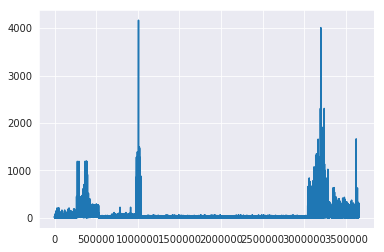

In [18]:
lst = [] 
for i in range(len(url_int_tokens)):
    lst.append(len(url_int_tokens[i]))
    
def Average(lst): 
    return sum(lst) / len(lst)

print(Average(lst))


import seaborn as sns

sns.set_style("darkgrid")
plt.plot(lst)
plt.show()

In [19]:
# Cut URL string at max_len or pad with zeros if shorter
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len, padding = 'post', truncating="post")
 
# Extract labels form df to numpy array
target = dataset["label"]

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (3655314, 400) Vector dimension of target:  (3655314,)


In [20]:
# Simple Cross-Validation: Split the data set into training and test data
X_train, X_test, target_train, target_test = model_selection.train_test_split(X, 
                                                                              target, 
                                                                              test_size=0.05, 
                                                                              random_state=32)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27, ratio=1.0)
X_train, target_train = sm.fit_sample(X_train, target_train)

[0.74835429 1.50662646]


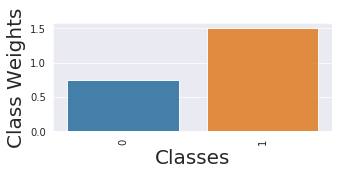

In [21]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(target_train),
                                                 target_train)
print(class_weights)

plt.figure(figsize = (5,2))
sns.barplot(np.unique(target_train), class_weights, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Classes', fontsize =20)
plt.ylabel('Class Weights', fontsize = 20)
plt.show()

In [22]:
max_vocab_len = 120
EMBEDDING_SIZE = 100

model = Sequential()
#model.add(Embedding(input_dim=max_vocab_len, output_dim=EMBEDDING_SIZE, input_length=max_len))
model.add(Embedding(max_vocab_len, EMBEDDING_SIZE, input_length=max_len))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
#model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_len, EMBEDDING_SIZE))))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.compile(optimizer= 'adam', 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 100)          12000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 128)          38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 182,241
Trainable params: 182,241
Non-trainable params: 0
_________________________________________________________________


In [24]:
# fit the model
results = model.fit(
                    X_train, target_train,
                    epochs= 25,
                    batch_size = 1000,
                    validation_data = (X_test, target_test),
                    class_weight= class_weights,
                    shuffle = True,
                    callbacks = [checkpoint, early_stopping]
                    )
model.save("myModel.h5")
print("Test-Accuracy:", np.mean(results.history["val_acc"]))

Instructions for updating:
Use tf.cast instead.
Train on 3472548 samples, validate on 182766 samples
Epoch 1/25
3472548/3472548 [==============================] - 683s 197us/step - loss: 0.4723 - acc: 0.7891 - val_loss: 0.3775 - val_acc: 0.8488

Epoch 00001: val_loss improved from inf to 0.37747, saving model to weightsU.best.hdf5
Epoch 2/25
3472548/3472548 [==============================] - 683s 197us/step - loss: 0.3759 - acc: 0.8490 - val_loss: 0.3572 - val_acc: 0.8566

Epoch 00002: val_loss improved from 0.37747 to 0.35718, saving model to weightsU.best.hdf5
Epoch 3/25
3472548/3472548 [==============================] - 683s 197us/step - loss: 0.3612 - acc: 0.8552 - val_loss: 0.3459 - val_acc: 0.8618

Epoch 00003: val_loss improved from 0.35718 to 0.34589, saving model to weightsU.best.hdf5
Epoch 4/25
3472548/3472548 [==============================] - 683s 197us/step - loss: 0.3527 - acc: 0.8587 - val_loss: 0.3406 - val_acc: 0.8639

Epoch 00004: val_loss improved from 0.34589 to 0.3

In [27]:
from sklearn.model_selection import StratifiedKFold
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# Cross validation

In [28]:
def createModel():
    max_vocab_len = 120
    EMBEDDING_SIZE = 100

    model = Sequential()
    #model.add(Embedding(input_dim=max_vocab_len, output_dim=EMBEDDING_SIZE, input_length=max_len))
    model.add(Embedding(max_vocab_len, EMBEDDING_SIZE, input_length=max_len))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    #model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_len, EMBEDDING_SIZE))))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer= 'adam', 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])
    return model
    

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=createModel, 
                                 epochs=20, 
                                 batch_size=1000, 
                                 verbose=0,
                                 shuffle = True,
                                 callbacks = [checkpoint, early_stopping])

In [33]:
# Evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, X, y, cv=3)

MemoryError: 

# Save Model

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_num.h5")

In [17]:
# load json and create model
json_file = open('model_num.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_num.h5")
print("Loaded model from disk")

loaded_model.save('model_num.hdf5')
loaded_model=load_model('model_num.hdf5')

Loaded model from disk


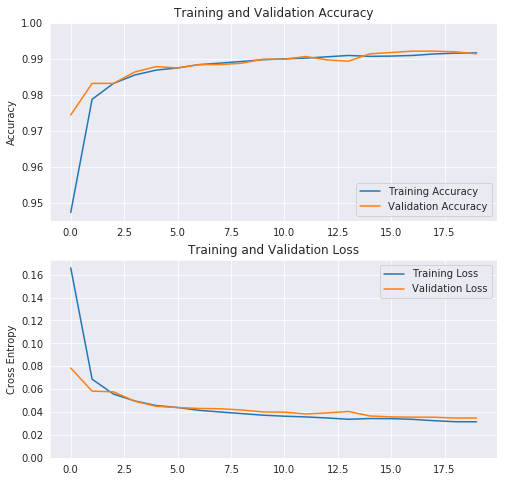

In [27]:
# plot the loss and accuracy 
import matplotlib.pyplot as plt

acc = results.history['acc']
val_acc = results.history['val_acc']

loss = results.history['loss']
val_loss = results.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model = keras.models.load_model('weights2.best.hdf5')

In [ ]:
import pickle
# save model
# save the model to disk
filename = 'finalized_model'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [28]:
from sklearn.metrics import confusion_matrix

predicted = (model.predict(X_test) > 0.5).astype(int)
matrix = confusion_matrix(target_test, predicted)
print(matrix)

[[4865   19]
 [  27  434]]


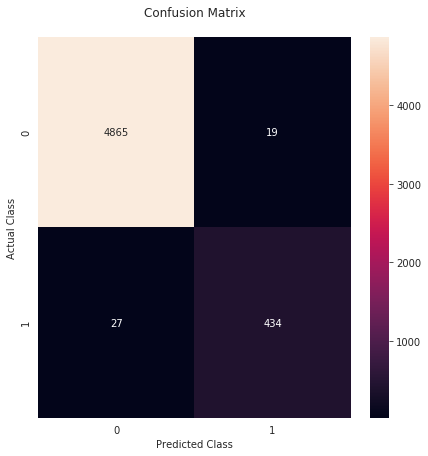

In [29]:
# Visualization Packages
import seaborn as sns

# Confusion Matrix Graph With Seaborn
plt.figure(figsize = (7,7))
plt.title('Confusion Matrix\n')

sns.heatmap(matrix,annot=True, fmt="d")
# Set x-axis label
plt.xlabel('Predicted Class')
# Set y-axis label
plt.ylabel('Actual Class')
plt.show()

In [30]:
from sklearn.metrics import classification_report

report = classification_report(target_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4884
           1       0.96      0.94      0.95       461

   micro avg       0.99      0.99      0.99      5345
   macro avg       0.98      0.97      0.97      5345
weighted avg       0.99      0.99      0.99      5345



In [85]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

roc_auc_score(target_test, predicted)

from sklearn.metrics import roc_curve

y_pred_keras = model.predict(X_test).ravel()


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

NameError: name 'y_test' is not defined

In [28]:
test_url_mal = "naureen.net/etisalat.ae/index2.pdf"
test_url_benign = ""

url = test_url_benign

# remove https/http/www.
l = re.compile(r"https?://(www\.)?")
urls = [l.sub('', url).strip().strip('/')]

# convert url to tokens
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable ] for url in urls]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
X = sequence.pad_sequences(url_int_tokens, maxlen=400)

In [29]:
target_proba = loaded_model.predict(X, batch_size=1)
def print_result(proba):
    if proba > 0.50:
        return "malicious"
    else:
        return "benign"
print("Test URL:", url, "is", print_result(target_proba[0]))

Test URL: chrome://downloads/ is malicious


In [9]:
def predict(x_input):
    #print(x_input)
    url_int_tokens_1=[[printable.index(x) + 1 for x in d if x in printable] for d in x_input]
    #print(url_int_tokens_1)
    X_1 = sequence.pad_sequences(url_int_tokens_1, maxlen=max_len)
    p = model.predict(X_1)
    print(p)
    #print(model.predict(X_1))
    return "not_malicious" if p < 0.75 else "malicious"
x_input=["google.com"]
print(predict(x_input))

NameError: name 'max_len' is not defined

# Pandas Data Processing

In [4]:
dataset=pd.read_csv("TopMillionSites.csv")
dataset.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,483629,2991753,google.com,com,1,1,483540,2987941
1,2,2,facebook.com,com,469285,3009693,facebook.com,com,2,2,469222,3006667
2,3,3,youtube.com,com,429837,2463186,youtube.com,com,3,3,429702,2459888
3,4,4,twitter.com,com,418811,2429507,twitter.com,com,4,4,418894,2427107
4,5,5,microsoft.com,com,312942,1204940,microsoft.com,com,5,5,312723,1204927


In [6]:
dataset.columns
alist = ['GlobalRank', 'TldRank','TLD', 'RefSubNets', 'RefIPs','IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 'PrevTldRank', 'PrevRefSubNets', 'PrevRefIPs']
filtered = dataset.drop(alist, axis = 1)
filtered.size
alist = []
for i in range(filtered.size):
      alist.append(0)
filtered.columns = ['url']
filtered.head()
filtered.to_csv('IndexCheckData.csv', sep=',', index=False)
    

In [50]:
filtered['label'] = alist
filtered.head()

,url,label
0,google.com,0
1,facebook.com,0
2,youtube.com,0
3,twitter.com,0
4,microsoft.com,0


In [51]:
filtered.to_csv('MillionData2.csv', sep=',', index=False)

In [23]:
dataset=pd.read_csv("data.csv")
dataset.head()

,url,label
0,google.com,good
1,diaryofagameaddict.com,bad
2,espdesign.com.au,bad
3,iamagameaddict.com,bad
4,kalantzis.net,bad


In [24]:
dataset.columns

Index(['url', 'label'], dtype='object')

In [25]:
data_classes = ["good", "bad"]
d = dict(zip(data_classes, [0,1]))
dataset['label'] = dataset['label'].map(d, na_action='ignore')

In [26]:
dataset.head()

,url,label
0,google.com,0
1,diaryofagameaddict.com,1
2,espdesign.com.au,1
3,iamagameaddict.com,1
4,kalantzis.net,1


In [27]:
dataset.to_csv('MillionData4.csv', sep=',', index=False)

In [30]:
df = pd.concat(map(pd.read_csv, ['MillionData.csv', 'MillionData2.csv','MillionData3.csv', 'MillionData4.csv']))

In [31]:
df.size

5344400

In [32]:
df.head()

,url,label
0,http://br-ofertasimperdiveis.epizy.com/produto...,1
1,https://semana-da-oferta.com/produtos.php?id=5...,1
2,https://scrid-apps-creacust-sslhide90766752024...,1
3,http://my-softbank-security.com/wap_login.htm,1
4,http://www.my-softbank-security.com/wap_login.htm,1


In [33]:
df.tail()

,url,label
420460,23.227.196.215/,1
420461,apple-checker.org/,1
420462,apple-iclods.org/,1
420463,apple-uptoday.org/,1
420464,apple-search.info,1


In [35]:
df.to_csv('FinalDataset.csv', sep=',', index=False)

In [36]:
dataset=pd.read_csv("FinalDataset.csv")

0    2442221
1     229979
Name: label, dtype: int64


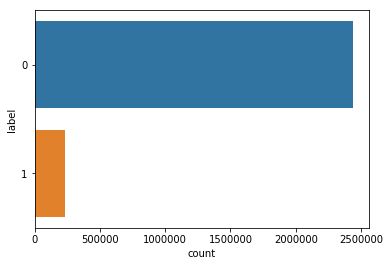

In [37]:
import seaborn
print(dataset["label"].value_counts())
seaborn.countplot(y="label", data=dataset);


In [72]:
import pandas as pd
dataset=pd.read_csv("Data/Data9.csv", error_bad_lines=False)
dataset.head()

b'Skipping line 4138: expected 1 fields, saw 4\nSkipping line 7532: expected 1 fields, saw 4\nSkipping line 11017: expected 1 fields, saw 4\nSkipping line 21217: expected 1 fields, saw 4\nSkipping line 22920: expected 1 fields, saw 4\nSkipping line 27865: expected 1 fields, saw 4\nSkipping line 27866: expected 1 fields, saw 4\nSkipping line 27867: expected 1 fields, saw 4\nSkipping line 27868: expected 1 fields, saw 4\nSkipping line 27869: expected 1 fields, saw 4\nSkipping line 27870: expected 1 fields, saw 4\nSkipping line 27871: expected 1 fields, saw 4\nSkipping line 27872: expected 1 fields, saw 4\nSkipping line 27873: expected 1 fields, saw 4\nSkipping line 27874: expected 1 fields, saw 4\nSkipping line 27875: expected 1 fields, saw 4\nSkipping line 27876: expected 1 fields, saw 4\nSkipping line 27877: expected 1 fields, saw 4\nSkipping line 27878: expected 1 fields, saw 4\nSkipping line 27879: expected 1 fields, saw 4\nSkipping line 27880: expected 1 fields, saw 4\nSkipping line

,url
0,http://jkncrew.com/d6qqocv-nyrbbg-ldkgwkr/
1,http://larissapharma.com/fobn/kdlkv-q1eeti2-jn...
2,http://kaysmarketing.com/mail//redirect.php?id...
3,http://kaysmarketing.com/mail/uploaded_images/...
4,http://epaint-village.com/wih-update/16zrs/lat...


In [73]:
dataset.size

167813

In [74]:
alist = []
for i in range(dataset.size):
      alist.append(1)
dataset['label'] = alist
dataset.head()

,url,label
0,http://jkncrew.com/d6qqocv-nyrbbg-ldkgwkr/,1
1,http://larissapharma.com/fobn/kdlkv-q1eeti2-jn...,1
2,http://kaysmarketing.com/mail//redirect.php?id...,1
3,http://kaysmarketing.com/mail/uploaded_images/...,1
4,http://epaint-village.com/wih-update/16zrs/lat...,1


In [75]:
dataset.to_csv('Dataset3.csv', sep=',', index=False)

In [83]:
dataset=pd.read_csv("Dataset3.csv")
dataset.head()

,url,label
0,http://jkncrew.com/d6qqocv-nyrbbg-ldkgwkr/,1
1,http://larissapharma.com/fobn/kdlkv-q1eeti2-jn...,1
2,http://kaysmarketing.com/mail//redirect.php?id...,1
3,http://kaysmarketing.com/mail/uploaded_images/...,1
4,http://epaint-village.com/wih-update/16zrs/lat...,1


In [103]:
df = pd.concat(map(pd.read_csv, ['Data/Data7.csv']))
df.head()

,url
0,0.r.msn.com
1,005.free-counter.co.uk
2,006.free-counter.co.uk
3,007.free-counter.co.uk
4,008.free-counter.co.uk


In [105]:
df.size

20753

In [106]:
alist = []
for i in range(df.size):
      alist.append(1)
print(len(alist))
df['label'] = alist
df.head()

20753


,url,label
0,0.r.msn.com,1
1,005.free-counter.co.uk,1
2,006.free-counter.co.uk,1
3,007.free-counter.co.uk,1
4,008.free-counter.co.uk,1


In [107]:
df.to_csv('Dataset5.csv', sep=',', index=False)
df=pd.read_csv("Dataset5.csv")
df.head()

,url,label
0,0.r.msn.com,1
1,005.free-counter.co.uk,1
2,006.free-counter.co.uk,1
3,007.free-counter.co.uk,1
4,008.free-counter.co.uk,1


In [118]:
df = pd.concat(map(pd.read_csv, ['Dataset.csv', 'FinalDataset.csv']))
df.head()
#df.drop("url",axis=0)

,url,label
0,001web.net,1
1,005mall.com,1
2,0dese-mi.com,1
3,0j9.ru,1
4,0l6.ru,1


In [122]:
#df.to_csv('Ultimate.csv', sep=',', index=False)
df=pd.read_csv("Ultimate.csv")
df.size


7310620

In [123]:
df.drop_duplicates(subset=None, keep='first', inplace=False)
df.size

7310620

In [ ]:
kill -9 $(nvidia-smi | awk '$2 == "GPU" && $3 == "PID" {flag = 1} flag && $3 > 0 {print $2, $3}' | awk '$1 < 4 && $2 > 1000 {print $2}')
